## Pupil Gluing Characterisation 🖌️

This notebook:
1. Calculates the Zernike coefficients on two separate starphire plates
2. Calculates the Zernike coefficients on the glued starphire setup

It is helpful to the phase retrieval process that data taken for the non-glued plates and glued setup have the same orientation.

Existing system aberrations are loaded and can be calculated using System_Aberrations.ipynb

In [1]:
import dLux as dl
import dLux.utils as dlu

import jax.numpy as jnp
import numpy as np
import jax.random as jr
import jax.scipy as jsp
from jax import vmap  
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", False)
jax.config.update('jax_disable_jit', False)

import zodiax as zdx
import optax
from tqdm.notebook import tqdm

from skimage.io import imread
from skimage.filters import window
import skimage as ski
from skimage.transform import resize

import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'upper' # true reading of array
plt.rcParams['figure.dpi'] = 72
plt.rcParams['figure.figsize'] = (10,10)
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["figure.titlesize"] = 18
plt.rcParams["axes.labelsize"] = 15

### System Parameters

In [2]:
# ------- Physical Parameters ---------------------------------------------------------------------#
aperture_npix = 512           # Number of pixels across the aperture
aperture_diameter = 126e-3#122e-3    # (m) slightly smaller for mask cap
spider_width = 20e-3          # Spider width (m)
spider_angle =270             # Spider angle (degrees), clockwise, 0 is spider pointing vertically up
coords = dlu.pixel_coords(npixels=aperture_npix, diameter=aperture_diameter)
circle = dlu.circle(coords=coords, radius=aperture_diameter/2) 

# Observations wavelengths (bandpass of 530-640nm)
red_laser_wl =  635e-09  # for laser data
green_laser_wl = 520e-09  # for laser data
wf_npixels = aperture_npix  # Number of pixels across the wavefront
wf_diam = aperture_diameter             # Diameter of initial wavefront to propagate wavefront (m)

# Detector parameters (BFS-U3-200S6-BD)
BFS_px_sep = 2.4e-6 *1e3        # pixel separation (mm)
f_det = 1300#1350                    # Focal length from OAP2 to detector (mm) 
px_ang_sep = 2*np.arctan( (BFS_px_sep/2)/f_det ) # angular sep between pixels (rad)

# Simulated Detector
psf_npix = 40                 # Number of pixels along one dim of the PSF
psf_hlf_sz = int(psf_npix/2)             # half window sz of cropped data
oversample = 1                 # Oversampling factor for the PSF
psf_pixel_scale = dlu.rad2arcsec(px_ang_sep) # arcsec (to match detector plate scale) 80e-4 

# Detector response (gamma curve)
# alpha = np.load("data/80us_detector/ALPHA_norm.npy")
# beta = np.load("data/80us_detector/BETA_norm.npy")
# gamma = np.load("data/80us_detector/GAMMA_norm.npy")
alpha = np.load("data/500us_detector/ALPHA_norm.npy")
beta = np.load("data/500us_detector/BETA_norm.npy")
gamma = np.load("data/500us_detector/GAMMA_norm.npy")

### Simulated Setup

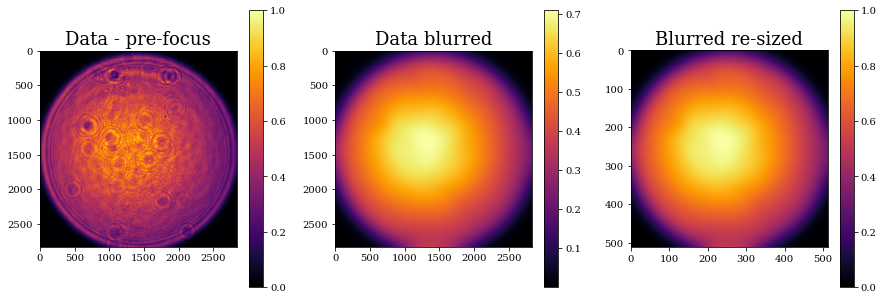

In [3]:
# In the setup, we have a fiber source. 
# Can model the intensity distribution using a Guassian or can just measure it directly
# Measuring directly also captures any mirror imperfections hindering transmission
fname = "data/intensity/15_07_intensity_dist.png"
data = imread(fname, as_gray=True) 
data= np.flipud(data) # det saves images fliiped upside down
manual_lim = [1363,4203,386,3214]
data = data[manual_lim[2]:manual_lim[3], manual_lim[0]:manual_lim[1]]
data = (data - data.min())/(data.max()-data.min())

blurred = ski.filters.gaussian(data, sigma=(120, 120))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(data)
plt.title("Data - pre-focus")
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(blurred)
plt.title("Data blurred")
plt.colorbar()
plt.subplot(1,3,3)
intensity_dist = resize(blurred, (aperture_npix, aperture_npix))
intensity_dist = (intensity_dist - intensity_dist.min())/(intensity_dist.max()-intensity_dist.min()) # re-map from 0-1
plt.title("Blurred re-sized")
plt.imshow(intensity_dist)
plt.colorbar()


#### System Aberrations 

We have an imperfect system. Load in the system aberrations (calculated using System_Aberrations.ipynb)

In [4]:
f_aberr = "data/spider/retrieval_results/16_09_mean_coeffs_combined.npy"
syst_noll = jnp.arange(4, 15) # only first 14 Zernike modes (excluding piston and tip/tilt) are used to classify syst aberrations
syst_coeffs = np.load(f_aberr)
syst_basis = dlu.zernike_basis(js=syst_noll, diameter=aperture_diameter, coordinates=coords)
print("System Coefficients (noll {}): {}".format(syst_noll,syst_coeffs))


System Coefficients (noll [ 4  5  6  7  8  9 10 11 12 13 14]): [ 5.34547523e-09 -7.48483795e-10  3.90298864e-09 -1.19804956e-09
 -7.88560215e-09  4.81785836e-09 -4.11487239e-09 -6.77422713e-09
  5.17982430e-11 -6.32650732e-10  1.59198803e-09]


Plate + Spider setup simulated

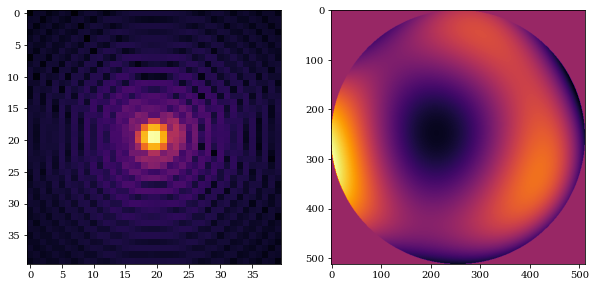

In [5]:
# Zernike aberrations
zernike_indicies = jnp.arange(4, 24) 
coeffs = jnp.zeros(zernike_indicies.shape)
basis = dlu.zernike_basis(js=zernike_indicies, coordinates=coords, diameter=aperture_diameter)

optical_systems = []
transmissions = []

# Using PointSources instead of single PointSource object to overcome float grad issue when solving for flux
green_src = dl.PointSources(wavelengths=[green_laser_wl], flux =jnp.asarray([1e8],dtype=float))
red_src = dl.PointSources(wavelengths=[red_laser_wl], flux =jnp.asarray([1e8],dtype=float))

spider_angles = [270, 180] #0deg is spider pointing vertically up, rotates CW from 0deg
optical_systems = []
transmissions = []
for i in range(len(spider_angles)):
    spider = dlu.spider(coords=coords, width=spider_width, angles=[spider_angles[i]])
    transmission = dlu.combine([circle, spider])*intensity_dist

    layers = [
        ('SystemAberrations', dl.layers.BasisOptic(basis=syst_basis, coefficients=syst_coeffs, normalise=False)),
        ('aperture', dl.layers.BasisOptic(basis=basis, transmission=transmission, coefficients=coeffs, normalise=False)),
    ]

    optics = dl.AngularOpticalSystem(wf_npixels = wf_npixels, 
                                diameter=wf_diam, 
                                layers=layers, 
                                psf_npixels=psf_npix, 
                                psf_pixel_scale=psf_pixel_scale,
                                oversample=oversample)

    optical_systems.append(optics)
    transmissions.append(transmission)

# Construct Optics
optics_sp270  = optical_systems[0]
optics_sp180 = optical_systems[1]
# Check PSF for aberrated system
layers = [
    ('SystemAberrations', dl.layers.BasisOptic(syst_basis, circle*intensity_dist, syst_coeffs, normalise=False)),
]

optics = dl.AngularOpticalSystem(wf_npixels = wf_npixels, 
                            diameter=wf_diam, 
                            layers=layers, 
                            psf_npixels=psf_npix, 
                            psf_pixel_scale=psf_pixel_scale,
                            oversample=oversample)

psf = optics.propagate_mono(green_laser_wl)
plt.subplot(1,2,1)
plt.imshow(psf**0.2)
opd = optics.SystemAberrations.eval_basis()
plt.subplot(1,2,2)
plt.imshow(opd)


### Load in single Starphire data

#### Phase Retrieval

In [6]:
params = [
    'aperture.coefficients',
    'source.position',
    'source.flux', 
    ]

learning_rate = 1e-9
optimisers = [
            optax.adam(learning_rate=learning_rate),
            optax.adam(learning_rate=1e-8),
            optax.adam(learning_rate=1e6),
              ]

@zdx.filter_jit
@zdx.filter_value_and_grad(params)
def loss_fn_poisson(model, data):

    simu_psf = model.model()

    loss = -jsp.stats.poisson.logpmf(k=simu_psf, mu=data).sum()

    return loss


### Lets loop this

#### Starphire 1

In [19]:
# Location on detector 
row_start, col_start = 1676, 2600 # Start coord of window on det where data was taken
row_len, col_len = 86, 76   # window size of recorded data

alpha_cropped = alpha[row_start:row_start+row_len, col_start:col_start+col_len]
beta_cropped = beta[row_start:row_start+row_len, col_start:col_start+col_len]
gamma_cropped = gamma[row_start:row_start+row_len, col_start:col_start+col_len]

# Order in increasing spider angle for each colour separately
img_fnames = [
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/16_09_starphire1_green_0deg_400us_0gain_img_stack_batch_0.npy",
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/16_09_starphire1_green_90deg_280us_0gain_img_stack_batch_0.npy",
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/16_09_starphire1_red_0deg_294us_0gain_img_stack_batch_0.npy",
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/16_09_starphire1_red_90deg_356us_0gain_img_stack_batch_0.npy",

    # "/Volumes/Morgana2/gpir9156/toliman/non_glued/5_09_starphire1_green_0deg_294us_0gain_img_stack_batch_0.npy", # with prev spider that let light through
    # "/Volumes/Morgana2/gpir9156/toliman/non_glued/5_09_starphire1_green_90deg_294us_0gain_img_stack_batch_0.npy",
    # "/Volumes/Morgana2/gpir9156/toliman/non_glued/5_09_starphire1_red_0deg_133us_0gain_img_stack_batch_0.npy",
    # "/Volumes/Morgana2/gpir9156/toliman/non_glued/5_09_starphire1_red_90deg_200us_0gain_img_stack_batch_0.npy",
    
]
labels = [
    "0deg_green",
    "90deg_green",
    "0deg_red",
    "90deg_red",
]
bckgnd_fnames = [
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/16_09_starphire1_green_0deg_bckgnd_400us_0gain_img_stack_batch_0.npy",
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/16_09_starphire1_green_90deg_bckgnd_280us_0gain_img_stack_batch_0.npy",
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/16_09_starphire1_green_0deg_bckgnd_400us_0gain_img_stack_batch_0.npy",
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/16_09_starphire1_green_90deg_bckgnd_280us_0gain_img_stack_batch_0.npy",
]
still_frame_idxs = [
    0, 0, 0, 0 # find_still_frame.py
]

imgs = np.asarray([np.flipud(np.load(img_fname)) for img_fname in img_fnames])
bckgnds = np.asarray([np.mean(np.flipud(np.load(bckgnd_fname)),axis=0) for bckgnd_fname in bckgnd_fnames])  # single bck

epochs = [
    5000, 5000,5000,5000,
]

Optimising on both spider orientations simultaneously 

Loss:   0%|          | 0/1000 [00:00<?, ?it/s]

Loss:   0%|          | 0/1000 [00:00<?, ?it/s]

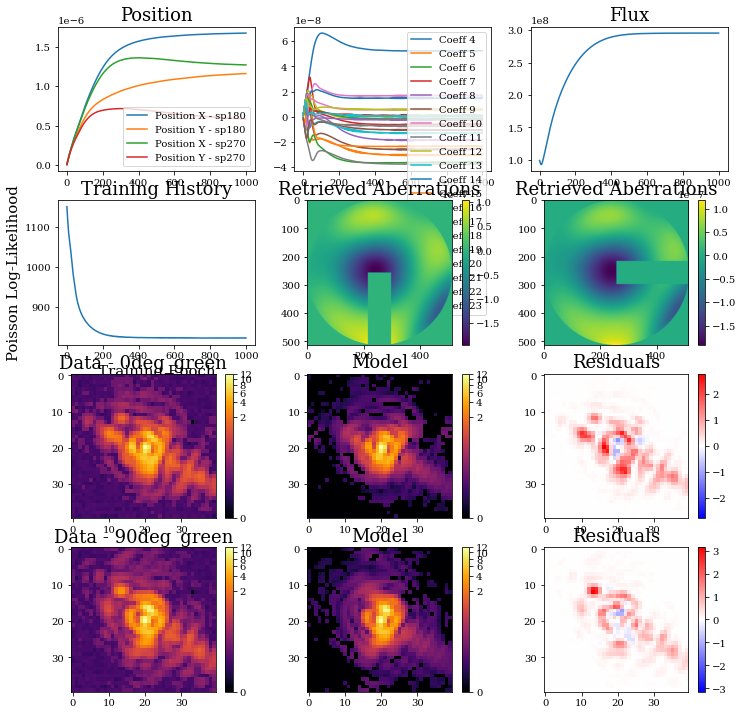

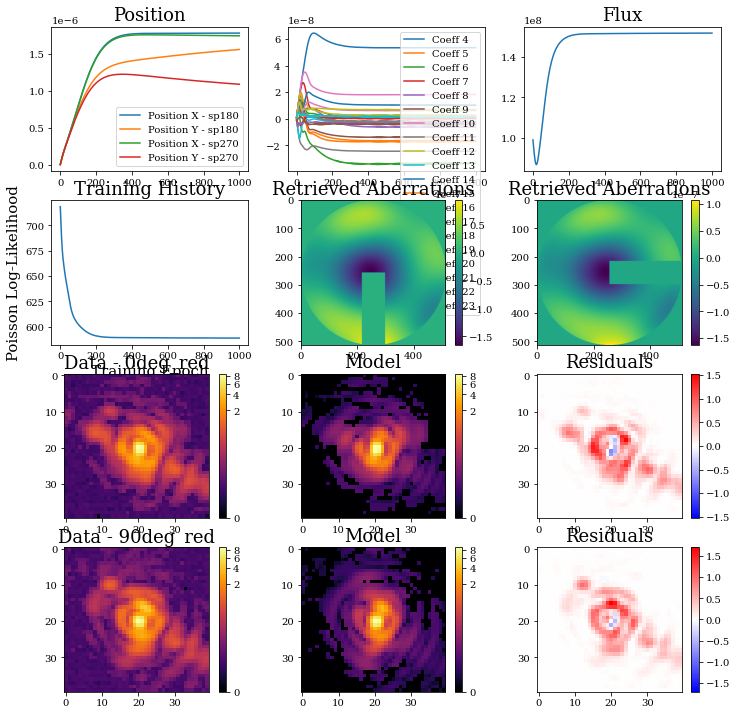

In [26]:
starphire1_coeffs, starphire1_pos = [], []

# 2 loops for 2 diff source colours
for i in range(2):
    data_idx = 2*i
    ###---------------------------- Re-init models ----------------------------###
    if i == 0:
        source = green_src
    else:
        source = red_src
    instrument_sp180 = dl.Telescope(optics_sp180, ('source', source))
    instrument_sp270 = dl.Telescope(optics_sp270, ('source', source))

    sim_psfs = [instrument_sp180.model(), instrument_sp270.model()]
    norm_psfs = [PowerNorm(0.2, vmax=sim_psf.max(), vmin=sim_psf.min()) for sim_psf in sim_psfs]    

    ###------------------------------- Get Data -----------------------------###
    data_sp180 = imgs[data_idx][still_frame_idxs[data_idx],:,:] #assuming only two spider configs, given in order of increasing angle for each colour
    data_sp270 = imgs[data_idx+1][still_frame_idxs[data_idx+1],:,:]
    data_list = [data_sp180, data_sp270]
    scaled_data_list = []
    for j in range(len(data_list)):
        data = data_list[j]
        data = data - bckgnds[j]

        # Reverse-model detector response
        data_remapped = 0.0 + ((1.0 - 0.0)/(data.max()-data.min()))*(data - data.min()) #[0,1] otput range
        data = np.power((data_remapped-np.flipud(alpha_cropped))/np.flipud(beta_cropped), (1/np.flipud(gamma_cropped))) # flip about origin

        # Scale intensity
        current_range = data.max() - data.min()
        new_range = sim_psfs[j].max() - sim_psfs[j].min()
        scaled_data = ( (data - data.min()) * new_range )/current_range + sim_psfs[j].min()

        psf_center_idx = np.unravel_index(np.argmax(scaled_data, axis=None), scaled_data.shape)
        scaled_data = scaled_data[psf_center_idx[0]-psf_hlf_sz:psf_center_idx[0]+psf_hlf_sz,
                                    psf_center_idx[1]-psf_hlf_sz:psf_center_idx[1]+psf_hlf_sz]
        
        scaled_data_list.append(scaled_data)
    ###------------------------------- Phase Retrieval -----------------------------###
    configs = [instrument_sp180, instrument_sp270]
    optim, opt_state = zdx.get_optimiser(instrument_sp180, params, optimisers) # Needs to be iterable param (i.e. accessible via instrument class)

    progress_bar = tqdm(range(1000), desc='Loss: ')

    # Run optimisation loop 
    net_losses, Coeffs, Positions_sp180, Positions_sp270, Fluxes= [],[],[],[],[]
    for j in progress_bar:
        grads = None
        net_loss = 0
        mean_coeff_grads, mean_position_grads, mean_flux_grads = None, None, None # to set initially in loop
        pos_grads = [] # update positional gradients separately (right now I've centered data based on brightest pixel
                        # but this is not a super robust method, so allow for source position difference)
        for k in range(len(configs)):
            loss, grads = loss_fn_poisson(model = configs[k], data = scaled_data_list[k])
            net_loss += loss 
            
            if k == 0:
                mean_coeff_grads = grads.aperture.coefficients/len(configs)
                mean_position_grads = grads.source.position/len(configs)
                mean_flux_grads = grads.source.flux/len(configs)
            else:
                mean_coeff_grads += grads.aperture.coefficients/len(configs)
                mean_position_grads += grads.source.position/len(configs)
                mean_flux_grads += grads.source.flux/len(configs)

            pos_grads.append(grads.source.position)

        grads = grads.set('aperture.coefficients', mean_coeff_grads)
        grads = grads.set('source.position', mean_position_grads)
        grads = grads.set('source.flux', mean_flux_grads)

        for k in range(len(configs)):
            grads = grads.set('source.position', pos_grads[k])
            updates, opt_state = optim.update(grads, opt_state)
            configs[k] = zdx.apply_updates(configs[k], updates)

        net_losses.append(net_loss)
        Fluxes.append(configs[0].source.flux)
        Coeffs.append(configs[0].aperture.coefficients)
        Positions_sp180.append(configs[0].source.position)
        Positions_sp270.append(configs[1].source.position)

        progress_bar.set_postfix({'Loss (combined)': net_loss})

    ###---------------------------------- Plotting ---------------------------------###
    plt.figure(figsize=(12,12))
    plt.subplot(4,3,1)
    plt.plot(np.asarray(Positions_sp180)[:,0,0], label="Position X - sp180")
    plt.plot(np.asarray(Positions_sp180)[:,0,1], label="Position Y - sp180")
    plt.plot(np.asarray(Positions_sp270)[:,0,0], label="Position X - sp270")
    plt.plot(np.asarray(Positions_sp270)[:,0,1], label="Position Y - sp270")
    plt.title("Position")
    plt.legend()
    plt.subplot(4,3,2)
    arr_coeffs = np.asarray(Coeffs)
    for l in range(len(Coeffs[0])):
        label = "Coeff " + str(zernike_indicies[l])
        plt.plot(arr_coeffs[:,l], label=label)
    plt.legend()
    plt.subplot(4,3,3)
    plt.plot(np.asarray(Fluxes))
    plt.title("Flux")
    plt.subplot(4,3,4)
    plt.plot(np.array(net_losses))
    ax = plt.gca()
    ax.set_title("Training History")
    ax.set_xlabel("Training Epoch")
    ax.set_ylabel("Poisson Log-Likelihood")

    it = 5
    for k, config in enumerate(configs):
        plt.subplot(4,3,it)
        opd = config.aperture.eval_basis()
        trans = config.aperture.transmission
        plt.imshow(opd*trans, cmap='viridis')
        plt.title('Retrieved Aberrations')
        plt.colorbar()
        it+=1

    for k, config in enumerate(configs):
        scaled_data = scaled_data_list[k]
        instrument = config

        plt.subplot(4,3,it)
        norm_psf = PowerNorm(0.2, vmax=scaled_data.max(), vmin=scaled_data.min())
        plt.imshow(scaled_data, norm=norm_psf)
        plt.colorbar()
        plt.title('Data - '+labels[data_idx+k])
        it+=1

        plt.subplot(4,3,it)
        model_psf = instrument.model()
        current_range = model_psf.max() - model_psf.min()
        new_range = scaled_data.max() - scaled_data.min()
        model_psf = ( (model_psf - model_psf.min()) * new_range )/current_range + scaled_data.min()
        norm_psf = PowerNorm(0.2, vmax=model_psf.max(), vmin=model_psf.min())
        mask = np.ones(scaled_data.shape)
        mask[scaled_data < 0.01] = 0
        plt.imshow(model_psf*mask, norm=norm_psf)
        plt.title('Model')
        plt.colorbar()
        it+=1

        plt.subplot(4,3,it)
        resid = scaled_data - model_psf
        plt.imshow(resid, cmap='bwr', vmax = np.abs(resid).max(), vmin = -np.abs(resid).max())
        plt.colorbar()
        plt.title('Residuals')
        it+=1
   
    starphire1_coeffs.append(configs[0].aperture.coefficients) # identical coeffs for both configs
    starphire1_pos.append([configs[0].source.position, configs[1].source.position])


Optimising on each spider orientation individually

In [ ]:
# starphire1_coeffs, starphire1_pos = [], []

# # no error bars, individual orientation fitting TODO sems all frames - not sure how to do simulatenous opt with mult images
# for i in range(len(img_fnames)): 
#     ###---------------------------- Re-init model ----------------------------###
#     if '_0deg_' in img_fnames[i]:
#         optics = optics_sp180
#     elif '_90deg_' in img_fnames[i]:
#         optics = optics_sp270
#     else:
#         ValueError("Unknown File format")

#     if 'green' in img_fnames[i]:
#         src = green_src
#     elif 'red' in img_fnames[i]:
#         src = red_src
#     else:
#         ValueError("Unknown File format")

#     instrument = dl.Telescope(optics, ('source', src))
#     sim_psf = instrument.model()
#     norm_psf = PowerNorm(0.2, vmax=sim_psf.max(), vmin=sim_psf.min())

#     ###------------------------------- Load data -----------------------------###
#     data = np.load(img_fnames[i])
#     data = data[still_frame_idxs[i],:,:] # using the most still frame (find_still_frame.py)

#     bckgnd = np.load(bckgnd_fnames[i])
#     bckgnd = np.mean(bckgnd)
#     data = data - bckgnd

#     data_remapped = 0.0 + ((1.0 - 0.0)/(data.max()-data.min()))*(data - data.min()) #[0,1] otput range
#     data_lin = np.power((data_remapped-np.flip(alpha_cropped))/np.flip(beta_cropped), (1/np.flip(gamma_cropped))) # flip about origin

#     # Scale intensity
#     data = data_lin
#     current_range = data.max() - data.min()
#     new_range = sim_psf.max() - sim_psf.min()
#     scaled_data = ( (data - data.min()) * new_range )/current_range + sim_psf.min()

#     psf_center_idx = np.unravel_index(np.argmax(scaled_data, axis=None), scaled_data.shape)
#     scaled_data = scaled_data[psf_center_idx[0]-psf_hlf_sz:psf_center_idx[0]+psf_hlf_sz,
#                                 psf_center_idx[1]-psf_hlf_sz:psf_center_idx[1]+psf_hlf_sz]

#     plt.figure(figsize=(10,5))
#     plt.subplot(1,2,1)
#     plt.imshow(scaled_data, norm=norm_psf)
#     plt.colorbar()
#     plt.title("Data (scaled)")
#     plt.subplot(1,2,2)
#     plt.imshow(sim_psf, norm=norm_psf)
#     plt.colorbar()
#     plt.title("Simulated")

#     ###------------------------------- Phase Retrieval -----------------------------###
#     optim, opt_state = zdx.get_optimiser(instrument, params, optimisers) # Needs to be iterable param (i.e. accessible via instrument class)

#     progress_bar = tqdm(range(epochs[i]), desc='Loss: ')

#     # Run optimisation loop 
#     net_losses, Coeffs, Positions, Fluxes= [],[],[],[]
#     for j in progress_bar:
#         poiss_loss, poiss_grads = loss_fn_poisson(model = instrument, data = scaled_data)

#         updates, opt_state = optim.update(poiss_grads, opt_state)
#         instrument = zdx.apply_updates(instrument, updates) 

#         net_losses.append(poiss_loss)
#         Fluxes.append(instrument.source.flux)
#         Coeffs.append(instrument.aperture.coefficients)
#         Positions.append(instrument.source.position)

#         progress_bar.set_postfix({'Loss': poiss_loss})
#     ###---------------------------------- Plotting ---------------------------------###
#     plt.figure(figsize=(11,3))
#     plt.subplot(1,4,1)
#     plt.plot(np.asarray(Positions)[:,0,0], label="Position X")
#     plt.plot(np.asarray(Positions)[:,0,1], label="Position Y")
#     plt.title("Position")
#     plt.legend()
#     plt.subplot(1,4,2)
#     arr_coeffs = np.asarray(Coeffs)
#     for k in range(len(Coeffs[0])):
#         label = "Coeff " + str(zernike_indicies[k])
#         plt.plot(arr_coeffs[:,k], label=label)
#     plt.legend()
#     plt.subplot(1,4,3)
#     plt.plot(np.asarray(Fluxes))
#     plt.title("Flux")
#     plt.subplot(1,4,4)
#     plt.plot(np.array(net_losses))
#     ax = plt.gca()
#     ax.set_title("Training History")
#     ax.set_xlabel("Training Epoch")
#     ax.set_ylabel("Poisson Log-Likelihood")


#     plt.figure(figsize=(12,10))
#     norm_psf = PowerNorm(0.2, vmax=scaled_data.max(), vmin=scaled_data.min())
#     plt.subplot(2,2,1)
#     plt.imshow(scaled_data, norm=norm_psf)
#     plt.colorbar()
#     plt.title('Data')

#     plt.subplot(2,2,2)
#     model_psf = instrument.model()
#     current_range = model_psf.max() - model_psf.min()
#     new_range = scaled_data.max() - scaled_data.min()
#     model_psf = ( (model_psf - model_psf.min()) * new_range )/current_range + scaled_data.min()
#     norm_psf = PowerNorm(0.2, vmax=model_psf.max(), vmin=model_psf.min())
#     mask = np.ones(scaled_data.shape)
#     mask[scaled_data < 0.01] = 0
#     plt.imshow(model_psf*mask, norm=norm_psf)
#     plt.title('Model')
#     plt.colorbar()

#     plt.subplot(2,2,3)
#     resid = scaled_data - model_psf
#     plt.imshow(resid, cmap='bwr', vmax = np.abs(resid).max(), vmin = -np.abs(resid).max())
#     plt.colorbar()
#     plt.title('Residuals')

#     plt.subplot(2,2,4)
#     opd = instrument.aperture.eval_basis()
#     transmission = instrument.aperture.transmission 
#     plt.imshow(opd*transmission, cmap='viridis')
#     plt.title('Retrieved Aberrations')
#     plt.colorbar()


#     print("Optimised Position: {}\nFlux: {}\nCoefficients: {}".format(instrument.source.position, instrument.source.flux, instrument.aperture.coefficients))

#     starphire1_coeffs.append(instrument.aperture.coefficients)
#     starphire1_pos.append(instrument.source.position)


green RMS WFE: 0.182lambda
red RMS WFE: 0.122lambda
Mean RMS WFE: 0.152lambda


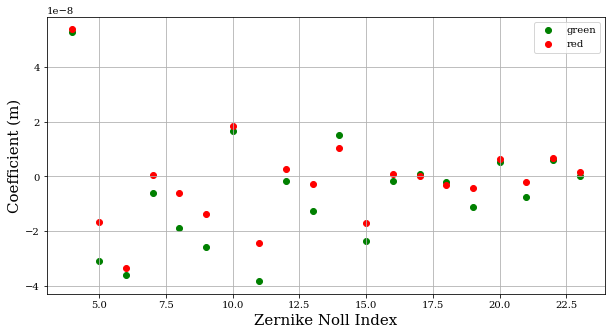

In [27]:
# Plot 
# WFE calc excluding piston, tip and tilt
plt.figure(figsize=(10,5))
wf_errs = []
labels = ['green', 'red']
# OR (depending on optimisation config)
# labels = [
#     "0deg_green",
#     "90deg_green",
#     "0deg_red",
#     "90deg_red",
# ]
for i,coeffs in enumerate(starphire1_coeffs):

    if 'red' in labels[i]:
        wl = red_laser_wl
        colour = 'r'
    elif 'green' in labels[i]:
        wl = green_laser_wl
        colour = 'g'
    else:
        ValueError("Unknown Wavelength")

    plt.scatter(zernike_indicies, coeffs, label=labels[i], c=colour)
    RMS_wf_err = ((coeffs**2).sum())**0.5

    print("{} RMS WFE: {:.3f}lambda".format(labels[i], RMS_wf_err/wl))
    wf_errs.append(RMS_wf_err/wl) 

plt.xlabel("Zernike Noll Index")
plt.ylabel("Coefficient (m)")
plt.grid()
plt.legend()

print("Mean RMS WFE: {:.3f}lambda".format(np.mean(wf_errs)))

Add Zernike coeff uncertainties once sure this is calc correctly

#### Starphire 2

In [28]:
img_fnames = [
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/16_09_starphire2_green_0deg_173us_0gain_img_stack_batch_0.npy",
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/16_09_starphire2_green_90deg_294us_0gain_img_stack_batch_0.npy",
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/16_09_starphire2_red_0deg_173us_0gain_img_stack_batch_0.npy",
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/16_09_starphire2_red_90deg_173us_0gain_img_stack_batch_0.npy",
    
]
labels = [
    "0deg_green",
    "90deg_green",
    "0deg_red",
    "90deg_red",
]
bckgnd_fnames = [
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/16_09_starphire2_green_0deg_bckgnd_173us_0gain_img_stack_batch_0.npy",
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/16_09_starphire2_red_90deg_bckgnd_173us_0gain_img_stack_batch_0.npy",
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/16_09_starphire2_green_0deg_bckgnd_173us_0gain_img_stack_batch_0.npy",
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/16_09_starphire2_red_90deg_bckgnd_173us_0gain_img_stack_batch_0.npy",
]
still_frame_idxs = [
    151, 163, 84, 113 # find_still_frame.py
]
imgs = np.asarray([np.flipud(np.load(img_fname)) for img_fname in img_fnames])
bckgnds = np.asarray([np.mean(np.flipud(np.load(bckgnd_fname)),axis=0) for bckgnd_fname in bckgnd_fnames]) 

epochs = [
    5000, 5000,5000,5000,
]

Loss:   0%|          | 0/1500 [00:00<?, ?it/s]

Loss:   0%|          | 0/1500 [00:00<?, ?it/s]

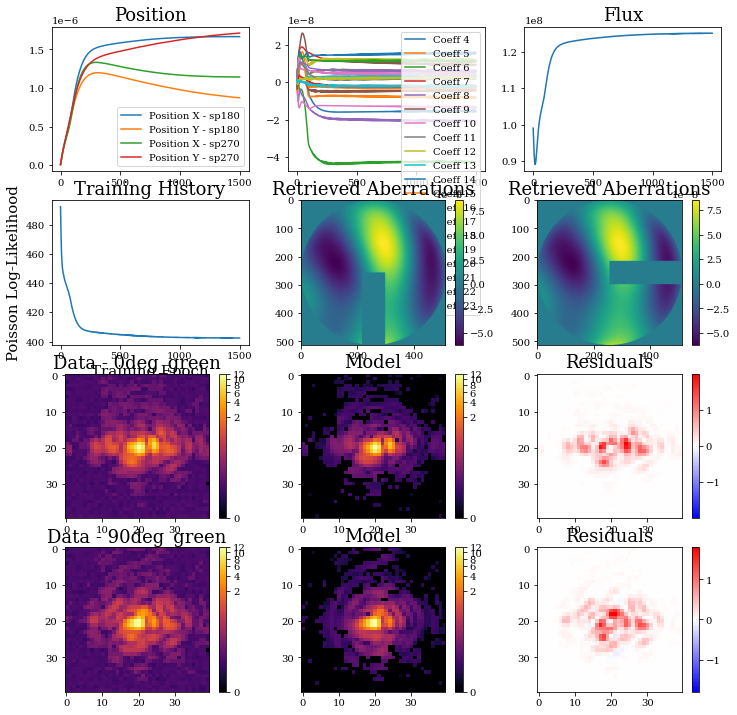

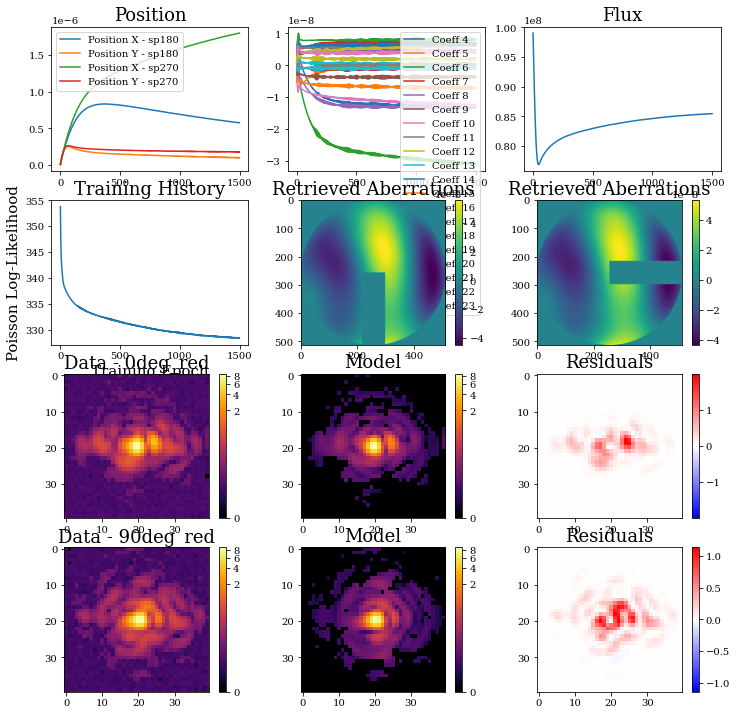

In [31]:
starphire2_coeffs, starphire2_pos = [], []

# 2 loops for 2 diff source colours
for i in range(2):
    ###---------------------------- Re-init models ----------------------------###
    if i == 0:
        source = green_src
    else:
        source = red_src
    instrument_sp180 = dl.Telescope(optics_sp180, ('source', source))
    instrument_sp270 = dl.Telescope(optics_sp270, ('source', source))

    sim_psfs = [instrument_sp180.model(), instrument_sp270.model()]
    norm_psfs = [PowerNorm(0.2, vmax=sim_psf.max(), vmin=sim_psf.min()) for sim_psf in sim_psfs]    

    ###------------------------------- Get Data -----------------------------###
    data_idx = 2*i
    data_sp180 = imgs[data_idx][still_frame_idxs[data_idx],:,:] #assuming only two spider configs, given in order of increasing angle for each colour
    data_sp270 = imgs[data_idx+1][still_frame_idxs[data_idx+1],:,:]
    data_list = [data_sp180, data_sp270]
    scaled_data_list = []
    for j in range(len(data_list)):
        data = data_list[j]
        data = data - bckgnds[j]

        # Reverse-model detector response
        data_remapped = 0.0 + ((1.0 - 0.0)/(data.max()-data.min()))*(data - data.min()) #[0,1] otput range
        data = np.power((data_remapped-np.flip(alpha_cropped))/np.flip(beta_cropped), (1/np.flip(gamma_cropped))) # flip about origin

        # Scale intensity
        current_range = data.max() - data.min()
        new_range = sim_psfs[j].max() - sim_psfs[j].min()
        scaled_data = ( (data - data.min()) * new_range )/current_range + sim_psfs[j].min()

        psf_center_idx = np.unravel_index(np.argmax(scaled_data, axis=None), scaled_data.shape)
        scaled_data = scaled_data[psf_center_idx[0]-psf_hlf_sz:psf_center_idx[0]+psf_hlf_sz,
                                    psf_center_idx[1]-psf_hlf_sz:psf_center_idx[1]+psf_hlf_sz]
        
        scaled_data_list.append(scaled_data)
    ###------------------------------- Phase Retrieval -----------------------------###
    configs = [instrument_sp180, instrument_sp270]
    optim, opt_state = zdx.get_optimiser(instrument_sp180, params, optimisers) # Needs to be iterable param (i.e. accessible via instrument class)

    progress_bar = tqdm(range(1500), desc='Loss: ')

    # Run optimisation loop 
    net_losses, Coeffs, Positions_sp180, Positions_sp270, Fluxes= [],[],[],[],[]
    for j in progress_bar:
        grads = None
        net_loss = 0
        mean_coeff_grads, mean_position_grads, mean_flux_grads = None, None, None # to set initially in loop
        pos_grads = [] # update positional gradients separately (right now I've centered data based on brightest pixel
                        # but this is not a super robust method, so allow for source position difference)
        for k in range(len(configs)):
            loss, grads = loss_fn_poisson(model = configs[k], data = scaled_data_list[k])
            net_loss += loss 
            
            if k == 0:
                mean_coeff_grads = grads.aperture.coefficients/len(configs)
                mean_position_grads = grads.source.position/len(configs)
                mean_flux_grads = grads.source.flux/len(configs)
            else:
                mean_coeff_grads += grads.aperture.coefficients/len(configs)
                mean_position_grads += grads.source.position/len(configs)
                mean_flux_grads += grads.source.flux/len(configs)

            pos_grads.append(grads.source.position)

        grads = grads.set('aperture.coefficients', mean_coeff_grads)
        grads = grads.set('source.position', mean_position_grads)
        grads = grads.set('source.flux', mean_flux_grads)

        for k in range(len(configs)):
            grads = grads.set('source.position', pos_grads[k])
            updates, opt_state = optim.update(grads, opt_state)
            configs[k] = zdx.apply_updates(configs[k], updates)

        net_losses.append(net_loss)
        Fluxes.append(configs[0].source.flux)
        Coeffs.append(configs[0].aperture.coefficients)
        Positions_sp180.append(configs[0].source.position)
        Positions_sp270.append(configs[1].source.position)

        progress_bar.set_postfix({'Loss (combined)': net_loss})

    ###---------------------------------- Plotting ---------------------------------###
    plt.figure(figsize=(12,12))
    plt.subplot(4,3,1)
    plt.plot(np.asarray(Positions_sp180)[:,0,0], label="Position X - sp180")
    plt.plot(np.asarray(Positions_sp180)[:,0,1], label="Position Y - sp180")
    plt.plot(np.asarray(Positions_sp270)[:,0,0], label="Position X - sp270")
    plt.plot(np.asarray(Positions_sp270)[:,0,1], label="Position Y - sp270")
    plt.title("Position")
    plt.legend()
    plt.subplot(4,3,2)
    arr_coeffs = np.asarray(Coeffs)
    for l in range(len(Coeffs[0])):
        label = "Coeff " + str(zernike_indicies[l])
        plt.plot(arr_coeffs[:,l], label=label)
    plt.legend()
    plt.subplot(4,3,3)
    plt.plot(np.asarray(Fluxes))
    plt.title("Flux")
    plt.subplot(4,3,4)
    plt.plot(np.array(net_losses))
    ax = plt.gca()
    ax.set_title("Training History")
    ax.set_xlabel("Training Epoch")
    ax.set_ylabel("Poisson Log-Likelihood")

    it = 5
    for k, config in enumerate(configs):
        plt.subplot(4,3,it)
        opd = config.aperture.eval_basis()
        trans = config.aperture.transmission
        plt.imshow(opd*trans, cmap='viridis')
        plt.title('Retrieved Aberrations')
        plt.colorbar()
        it+=1

    for k, config in enumerate(configs):
        scaled_data = scaled_data_list[k]
        instrument = config

        plt.subplot(4,3,it)
        norm_psf = PowerNorm(0.2, vmax=scaled_data.max(), vmin=scaled_data.min())
        plt.imshow(scaled_data, norm=norm_psf)
        plt.colorbar()
        plt.title('Data - '+labels[data_idx+k])
        it+=1

        plt.subplot(4,3,it)
        model_psf = instrument.model()
        current_range = model_psf.max() - model_psf.min()
        new_range = scaled_data.max() - scaled_data.min()
        model_psf = ( (model_psf - model_psf.min()) * new_range )/current_range + scaled_data.min()
        norm_psf = PowerNorm(0.2, vmax=model_psf.max(), vmin=model_psf.min())
        mask = np.ones(scaled_data.shape)
        mask[scaled_data < 0.01] = 0
        plt.imshow(model_psf*mask, norm=norm_psf)
        plt.title('Model')
        plt.colorbar()
        it+=1

        plt.subplot(4,3,it)
        resid = scaled_data - model_psf
        plt.imshow(resid, cmap='bwr', vmax = np.abs(resid).max(), vmin = -np.abs(resid).max())
        plt.colorbar()
        plt.title('Residuals')
        it+=1
   
    starphire2_coeffs.append(configs[0].aperture.coefficients) # identical coeffs for both configs
    starphire2_pos.append([configs[0].source.position, configs[1].source.position])


In [ ]:
# Plot 
# WFE calc excluding piston, tip and tilt
plt.figure(figsize=(10,5))
wf_errs = []
labels = ['green', 'red']
for i,coeffs in enumerate(starphire2_coeffs):
    if 'red' in labels[i]:
        wl = red_laser_wl
        colour = 'r'
    elif 'green' in labels[i]:
        wl = green_laser_wl
        colour = 'g'
    else:
        ValueError("Unknown Wavelength")

    plt.scatter(zernike_indicies, coeffs, label=labels[i], c=colour)
    RMS_wf_err = ((coeffs**2).sum())**0.5

    print("{} RMS WFE: {:.3f}lambda".format(labels[i], RMS_wf_err/wl))
    wf_errs.append(RMS_wf_err/wl) 

plt.xlabel("Zernike Noll Index")
plt.ylabel("Coefficient (m)")
plt.grid()
plt.legend()

print("Mean RMS WFE: {:.3f}lambda".format(np.mean(wf_errs)))

Comparing plates

In [ ]:
plt.figure(figsize=(15,5))
titles = ["Green Data", "Red Data"]
wls = [green_laser_wl, red_laser_wl]   

subplt_it = 1
for i in range(len(titles)):
    plt.subplot(1,2,subplt_it)
    plt.title(titles[i])
    plt.scatter(zernike_indicies, starphire1_coeffs[i]/wls[i], label="Starphire 1")
    plt.scatter(zernike_indicies, starphire2_coeffs[i]/wls[i], label="Starphire 2")
    plt.scatter(zernike_indicies, (starphire1_coeffs[i]+starphire2_coeffs[i])/wls[i], label="1+2")
    plt.xlabel("Zernike Noll Index")
    plt.ylabel("OPD (multiple of wl)")
    plt.legend()
    plt.grid()

    subplt_it+=1


#### Glued plates

Will need to simulate with both spider setups again

In [ ]:
# re-init sim with bigger fov
# Simulated Detector
psf_npix = 150                 # Number of pixels along one dim of the PSF
psf_hlf_sz = int(psf_npix/2)   # half window sz of cropped data

# Construct Optics
optics = dl.AngularOpticalSystem(wf_npixels = wf_npixels, 
                                diameter=wf_diam, 
                                layers=layers, 
                                psf_npixels=psf_npix, 
                                psf_pixel_scale=psf_pixel_scale,
                                oversample=oversample)


instrument = dl.Telescope(optics, ('source', src))
sim_psf = instrument.model()


In [ ]:
# Location on detector 
row_start, col_start = 1670, 2580 # Start coord of window on det where data was taken
row_len, col_len =500,500   # window size of recorded data

alpha_cropped = alpha[row_start:row_start+row_len, col_start:col_start+col_len]
beta_cropped = beta[row_start:row_start+row_len, col_start:col_start+col_len]
gamma_cropped = gamma[row_start:row_start+row_len, col_start:col_start+col_len]

img_fnames = [
    "/Volumes/Morgana2/gpir9156/toliman/glued/15_08_green_149us_19.5gain_img_stack_batch_0.npy",
    "/Volumes/Morgana2/gpir9156/toliman/glued/15_08_red_149us_19.5gain_img_stack_batch_0.npy",
]
bckgnd_fnames = [
    "/Volumes/Morgana2/gpir9156/toliman/glued/15_08_bckgnd_149us_19.5gain_img_stack_batch_0.npy",
    "/Volumes/Morgana2/gpir9156/toliman/glued/15_08_bckgnd_149us_19.5gain_img_stack_batch_0.npy",
]
still_frame_idxs = [
    32,36 # find_still_frame.py
]
epochs = [
    10000, 5000
]

In [ ]:
green_glued_coeffs = None
red_glued_coeffs = None

for i in range(len(img_fnames)):
    ###---------------------------- Re-init model ----------------------------###
    instrument = dl.Telescope(optics, ('source', src))
    sim_psf = instrument.model()

    ###------------------------------- Load data -----------------------------###
    data = np.load(img_fnames[i])
    data = data[still_frame_idxs[i],:,:] # using the most still frame (find_still_frame.py)

    bckgnd = np.load(bckgnd_fnames[i])
    bckgnd = np.mean(bckgnd)
    data = data - bckgnd

    data_remapped = 0.0 + ((1.0 - 0.0)/(data.max()-data.min()))*(data - data.min()) #[0,1] otput range
    data_lin = np.power((data_remapped-np.flip(alpha_cropped))/np.flip(beta_cropped), (1/np.flip(gamma_cropped))) # flip about origin

    # Scale intensity
    data = data_lin
    current_range = data.max() - data.min()
    new_range = sim_psf.max() - sim_psf.min()
    scaled_data = ( (data - data.min()) * new_range )/current_range + sim_psf.min()

    psf_center_idx = np.unravel_index(np.argmax(scaled_data, axis=None), scaled_data.shape)
    scaled_data = scaled_data[psf_center_idx[0]-psf_hlf_sz:psf_center_idx[0]+psf_hlf_sz,
                                psf_center_idx[1]-psf_hlf_sz:psf_center_idx[1]+psf_hlf_sz]

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(scaled_data, norm=norm_psf)
    plt.colorbar()
    plt.title("Data (scaled)")
    plt.subplot(1,2,2)
    plt.imshow(sim_psf, norm=norm_psf)
    plt.colorbar()
    plt.title("Simulated")

    ###------------------------------- Phase Retrieval -----------------------------###
    optim, opt_state = zdx.get_optimiser(instrument, params, optimisers) # Needs to be iterable param (i.e. accessible via instrument class)

    progress_bar = tqdm(range(epochs[i]), desc='Loss: ')

    # Run optimisation loop 
    net_losses, Coeffs, Positions, Fluxes= [],[],[],[]
    for j in progress_bar:
        poiss_loss, poiss_grads = loss_fn_poisson(model = instrument, data = scaled_data)

        updates, opt_state = optim.update(poiss_grads, opt_state)
        instrument = zdx.apply_updates(instrument, updates) 

        net_losses.append(poiss_loss)
        Fluxes.append(instrument.source.flux)
        Coeffs.append(instrument.aperture.coefficients)
        Positions.append(instrument.source.position)

        progress_bar.set_postfix({'Loss': poiss_loss})
    ###---------------------------------- Plotting ---------------------------------###
    plt.figure(figsize=(11,3))
    plt.subplot(1,4,1)
    plt.plot(np.asarray(Positions)[:,0,0], label="Position X")
    plt.plot(np.asarray(Positions)[:,0,1], label="Position Y")
    plt.title("Position")
    plt.legend()
    plt.subplot(1,4,2)
    arr_coeffs = np.asarray(Coeffs)
    for k in range(len(Coeffs[0])):
        label = "Coeff " + str(zernike_indicies[k])
    plt.plot(arr_coeffs[:,k], label=label)
    plt.legend()
    plt.subplot(1,4,3)
    plt.plot(np.asarray(Fluxes))
    plt.title("Flux")
    plt.subplot(1,4,4)
    plt.plot(np.array(net_losses))
    ax = plt.gca()
    ax.set_title("Training History")
    ax.set_xlabel("Training Epoch")
    ax.set_ylabel("Poisson Log-Likelihood")


    plt.figure(figsize=(12,10))
    norm_psf = PowerNorm(0.2, vmax=scaled_data.max(), vmin=scaled_data.min())
    plt.subplot(2,2,1)
    plt.imshow(scaled_data, norm=norm_psf)
    plt.colorbar()
    plt.title('Data')

    plt.subplot(2,2,2)
    model_psf = instrument.model()
    current_range = model_psf.max() - model_psf.min()
    new_range = scaled_data.max() - scaled_data.min()
    model_psf = ( (model_psf - model_psf.min()) * new_range )/current_range + scaled_data.min()
    norm_psf = PowerNorm(0.2, vmax=model_psf.max(), vmin=model_psf.min())
    mask = np.ones(scaled_data.shape)
    mask[scaled_data < 0.01] = 0
    plt.imshow(model_psf*mask, norm=norm_psf)
    plt.title('Model')
    plt.colorbar()

    plt.subplot(2,2,3)
    resid = scaled_data - model_psf
    plt.imshow(resid, cmap='bwr', vmax = np.abs(resid).max(), vmin = -np.abs(resid).max())
    plt.colorbar()
    plt.title('Residuals')

    plt.subplot(2,2,4)
    opd = instrument.aperture.eval_basis()
    plt.imshow(opd*transmission, cmap='viridis')
    plt.title('Retrieved Aberrations')
    plt.colorbar()


    print("Optimised Position: {}\nFlux: {}\nCoefficients: {}".format(instrument.source.position, instrument.source.flux, instrument.aperture.coefficients))

    if 'green' in img_fnames[i]:
        green_glued_coeffs = instrument.aperture.coefficients
    elif 'red' in img_fnames[i]:
        red_glued_coeffs = instrument.aperture.coefficients
    else:
        ValueError("Unknown wavel")

In [ ]:
# coeffs comparison
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("Green Data")
plt.plot(zernike_indicies, green_glued_coeffs/green_laser_wl, label="Glued")
plt.plot(zernike_indicies, (green_coeffs[1]+green_coeffs[2])/green_laser_wl, label="1+2")
plt.xlabel("Zernike Noll Index")
plt.ylabel("OPD (multiple of wl)")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.title("Red Data")
plt.plot(zernike_indicies, red_glued_coeffs/red_laser_wl, label="Glued")
plt.plot(zernike_indicies, (red_coeffs[1]+red_coeffs[2])/red_laser_wl, label="1+2")
plt.legend()
plt.grid()
plt.xlabel("Zernike Noll Index")

In [ ]:
# PSF comparsion (just one colour for now)
%matplotlib inline
plt.figure(figsize=(11,10))
plt.suptitle("Green")
plt.subplot(2,2,1)
plt.title("Model (Glued)")
instrument = dl.Telescope(optics, ('source', src))
instrument = instrument.set('aperture.coefficients', green_glued_coeffs)
model_psf = instrument.model()
norm_psf = PowerNorm(0.2, vmax=model_psf.max(), vmin=model_psf.min())
plt.imshow(model_psf, norm=norm_psf)
plt.colorbar(label="Intensity")

plt.subplot(2,2,3)
opd = instrument.aperture.eval_basis()
plt.imshow(opd/green_laser_wl)
plt.colorbar(label="OPD (multiple of wl)")

RMS_wf_err0 = ((green_glued_coeffs**2).sum())**0.5
print("Glued wf error: {}lambda".format(RMS_wf_err0/green_laser_wl))
RMS_wf_err1 = ((green_coeffs[1]**2).sum())**0.5
RMS_wf_err2 = ((green_coeffs[2]**2).sum())**0.5
print("Starphire 1: {}lambda, Starphire 2: {}lambda".format(RMS_wf_err1/green_laser_wl, RMS_wf_err2/green_laser_wl))

plt.subplot(2,2,2)
plt.title("Model (Ideal Glued)")
instrument = dl.Telescope(optics, ('source', src))
tot_z = green_coeffs[1]+green_coeffs[2]
instrument = instrument.set('aperture.coefficients', tot_z)
model_psf = instrument.model()
norm_psf = PowerNorm(0.2, vmax=model_psf.max(), vmin=model_psf.min())
plt.imshow(model_psf, norm=norm_psf)
plt.colorbar(label="Intensity")

plt.subplot(2,2,4)
opd = instrument.aperture.eval_basis()
plt.imshow(opd/green_laser_wl)
plt.colorbar(label="OPD (multiple of wl)")

